# Load packages

In [1]:
setwd("~/work/ampra1")

In [2]:
pacman::p_load(
  ggplot2,
  patchwork,
  dplyr,
  magrittr,
  cetcolor,
  seriation,
  data.table,
  pheatmap
)

In [3]:
source("R/theme-clean.R")

In [4]:
# devtools::install_github("coatless/cetcolor")

In [5]:
meta_colors <- list(
  "cytof_cluster" = c(
    # Fibroblast
    "CD90- Cadherin.11-"   = "#E41A1C",
    "CD90- Cadherin.11+"   = "#377EB8",
    "CD90- CD34- HLA-DR+"  = "#4DAF4A",
    "CD90- CD34+ HLA-DR+"  = "#984EA3",
    "CD90+ CD34- HLA-DR-"  = "#FF7F00",
    "CD90+ CD34- HLA-DR+"  = "#FFFF33",
    "CD90+ CD34+ HLA-DR-"  = "#A65628",
    "CD90+ CD34+ HLA-DR+"  = "#F781BF",
    # Monocyte
    "CD11c-"               = "#E41A1C",
    "CD11c+ CCR2+"         = "#377EB8",
    "CD11c+ CD38-"         = "#4DAF4A",
    "CD11c+ CD38- CD64+"   = "#984EA3",
    "CD11c+ CD38+"         = "#FF7F00",
    # T cell
    "CD4- CD8-"            = "#E41A1C",
    "CD4+ CCR2+"           = "#377EB8",
    "CD4+ HLA-DR+"         = "#4DAF4A",
    "CD4+ PD-1+ ICOS-"     = "#984EA3",
    "CD4+ PD-1+ ICOS+"     = "#FF7F00",
    "CD8+"                 = "#FFFF33",
    "CD8+ HLA-DR+"         = "#A65628",
    "CD8+ PD-1+"           = "#F781BF",
    "CD8+ PD-1+ HLA-DR+"   = "#999999",
    # B cell
    "CD38+ CD20- Ig-"      = "#E41A1C",
    "CD38+ CD20- IgM+"     = "#377EB8",
    "HLA-DR- Ig-"          = "#4DAF4A",
    "HLA-DR+ CD20- CD11c+" = "#984EA3",
    "HLA-DR+ CD20+ CD11c+" = "#FF7F00",
    "HLA-DR+ Ig-"          = "#FFFF33",
    "IgA+ IgM- IgD-"       = "#A65628",
    "IgM+ IgD-"            = "#F781BF",
    "IgM+ IgD+"            = "#999999"
  ),
  "Disease" = c(
    "OA"              = "#6A3D9A",
    "non-inflamed RA" = "#FFD8B2",
    "inflamed RA"     = "#FF7F00"
  ),
  "Cell Type" = c(
    "B cell"     = "#E31A1C",
    "Fibroblast" = "#08519C",
    "Monocyte"   = "#DE77AE",
    "T cell"     = "#A65628" 
  )
)

In [6]:
# Return a dataframe where 'col1' and 'col2' are factors with levels in order.
seriate_cols <- function(d, col1, col2, value.var = "percent") {
  mat <- dcast(
    data = d,
    formula = as.formula(sprintf("%s ~ %s", col1, col2)),
    value.var = value.var
  )
  rownames(mat) <- mat[[1]]
  mat[[1]] <- NULL
  mat <- as.matrix(mat)
  mat[is.na(mat)] <- 0
  mat_order <- seriate(mat, method = "BEA_TSP")
  d[[col1]] <- factor(as.character(d[[col1]]), rownames(mat)[mat_order[[1]]])
  d[[col2]] <- factor(as.character(d[[col2]]), colnames(mat)[mat_order[[2]]])
  return(d)
}

# Load data and compute percents

In [7]:
d <- readRDS("data/cytof_plot.rds")

# 'percent_donor'
# is the percent of the donor's cells in this cluster,
# where all four cell types are pooled together.
d %<>% group_by(donor) %>% mutate(percent_donor = 100 * cells / sum(cells))

# 'percent_donor_cell_type'
# is the percent of the donor's cells in this cluster,
# where each cell type is 100%
d %<>% group_by(donor, cell_type) %>% mutate(percent_donor_cell_type = 100 * cells / sum(cells))

# 'percent_cluster'
# is the percent of each cluster's cells in this donor.
d %<>% group_by(cluster, cell_type) %>% mutate(percent_cluster = 100 * cells / sum(cells))

head(d)

donor,cluster,cells,cell_type,Disease,Tissue.type,Mahalanobis_20,percent_donor,percent_donor_cell_type,percent_cluster
300-0482,CD90- Cadherin.11-,23,Fibroblast,RA,biopsy,inflamed RA,0.575,2.3,0.5308101
300-0482,CD90- Cadherin.11+,17,Fibroblast,RA,biopsy,inflamed RA,0.425,1.7,0.4530917
300-0482,CD90- CD34+ HLA-DR+,29,Fibroblast,RA,biopsy,inflamed RA,0.725,2.9,1.9674355
300-0482,CD90- CD34- HLA-DR+,296,Fibroblast,RA,biopsy,inflamed RA,7.400,29.6,7.0966195
300-0482,CD90+ CD34- HLA-DR+,389,Fibroblast,RA,biopsy,inflamed RA,9.725,38.9,15.0950718
300-0482,CD90+ CD34- HLA-DR-,138,Fibroblast,RA,biopsy,inflamed RA,3.450,13.8,3.6373221


# PCA on mass cytometry cluster cell counts

In [8]:
mat <- dcast(data = d, formula = donor ~ cluster, value.var = "cells")
rownames(mat) <- mat[[1]]
mat[[1]] <- NULL
mat <- as.matrix(mat)
mat[is.na(mat)] <- 0
mat[1:5,1:5]
dim(mat)

pca <- summary(prcomp(x = mat, scale = TRUE))

d_donor <- as.data.frame(unique(d[,c("donor", "Mahalanobis_20")]))
rownames(d_donor) <- d_donor$donor
d_pca <- cbind(d_donor[rownames(pca$x),], pca$x)

,CD11c-,CD11c+ CCR2+,CD11c+ CD38-,CD11c+ CD38+,CD11c+ CD38- CD64+
300-0482,106,204,40,605,45
300-0483,41,430,6,448,75
300-0486,31,314,50,594,11
300-0487,29,426,4,529,12
300-0511,29,543,4,411,13


[1] 26 31

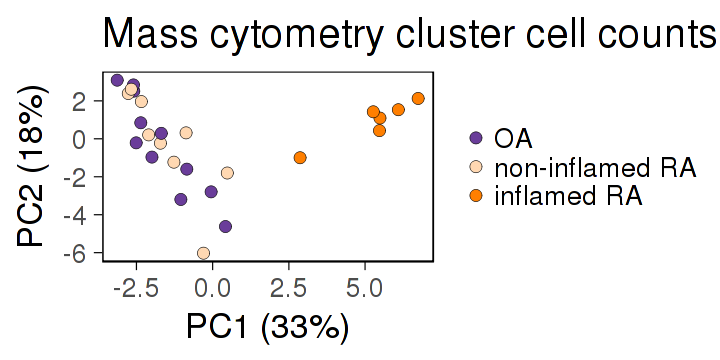

In [9]:
options(repr.plot.width = 6, repr.plot.height = 3)

ggplot(d_pca, aes(PC1, PC2, fill = Mahalanobis_20)) +
geom_point(size = 3, shape = 21, stroke = 0.2) +
scale_fill_manual(name = NULL, values = meta_colors$Disease) +
theme_clean(base_size = 20) +
labs(
  x = sprintf("PC1 (%.0f%%)", 100 * pca$importance[2,1]),
  y = sprintf("PC2 (%.0f%%)", 100 * pca$importance[2,2]),
  title = "Mass cytometry cluster cell counts"
)

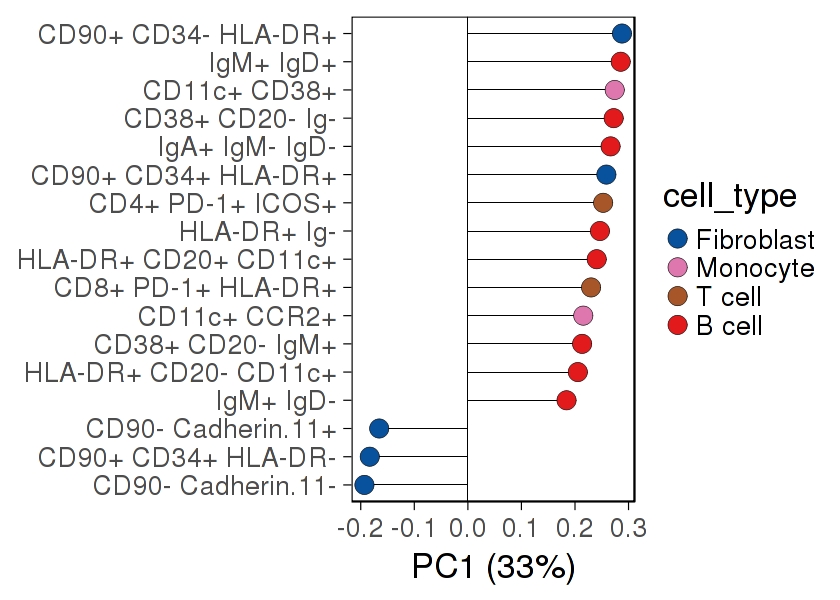

In [10]:
options(repr.plot.width = 7, repr.plot.height = 5)

d_cell_type <- as.data.frame(unique(d[,c("cluster", "cell_type")]))
rownames(d_cell_type) <- d_cell_type$cluster
d_load <- cbind(d_cell_type[rownames(pca$rotation),], pca$rotation)

ggplot(
  data = subset(d_load, abs(PC1) > 0.15),
  mapping = aes(x = reorder(cluster, PC1), y = PC1, fill = cell_type)
) +
geom_hline(yintercept = 0, size = 0.2) +
geom_segment(mapping = aes(xend = cluster, yend = 0), size = 0.2) +
geom_point(shape = 21, size = 5, stroke = 0.2) +
coord_flip() +
scale_fill_manual(values = meta_colors$`Cell Type`) +
theme_clean(base_size = 20) +
labs(x = NULL, y = sprintf("PC1 (%.0f%%)", 100 * pca$importance[2,1]))

# Heatmaps

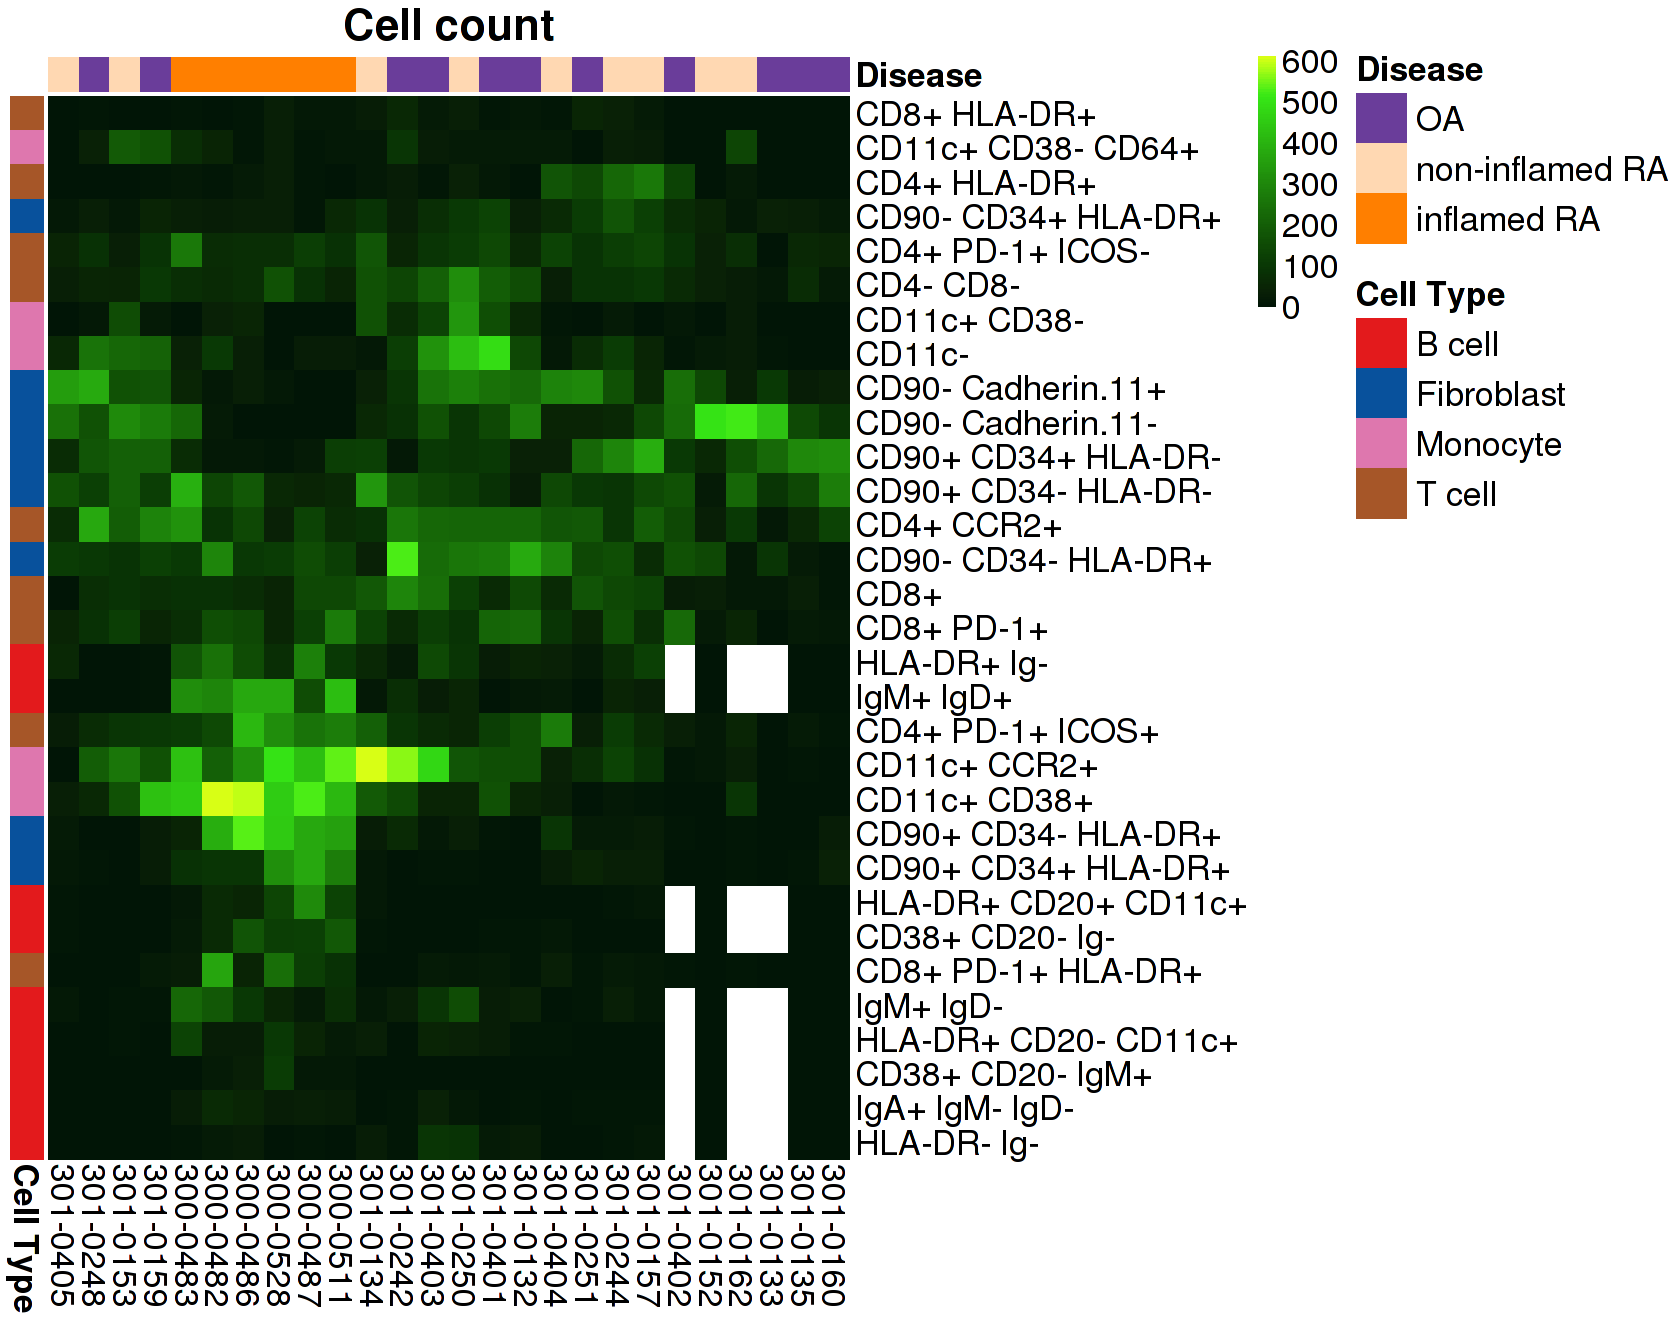

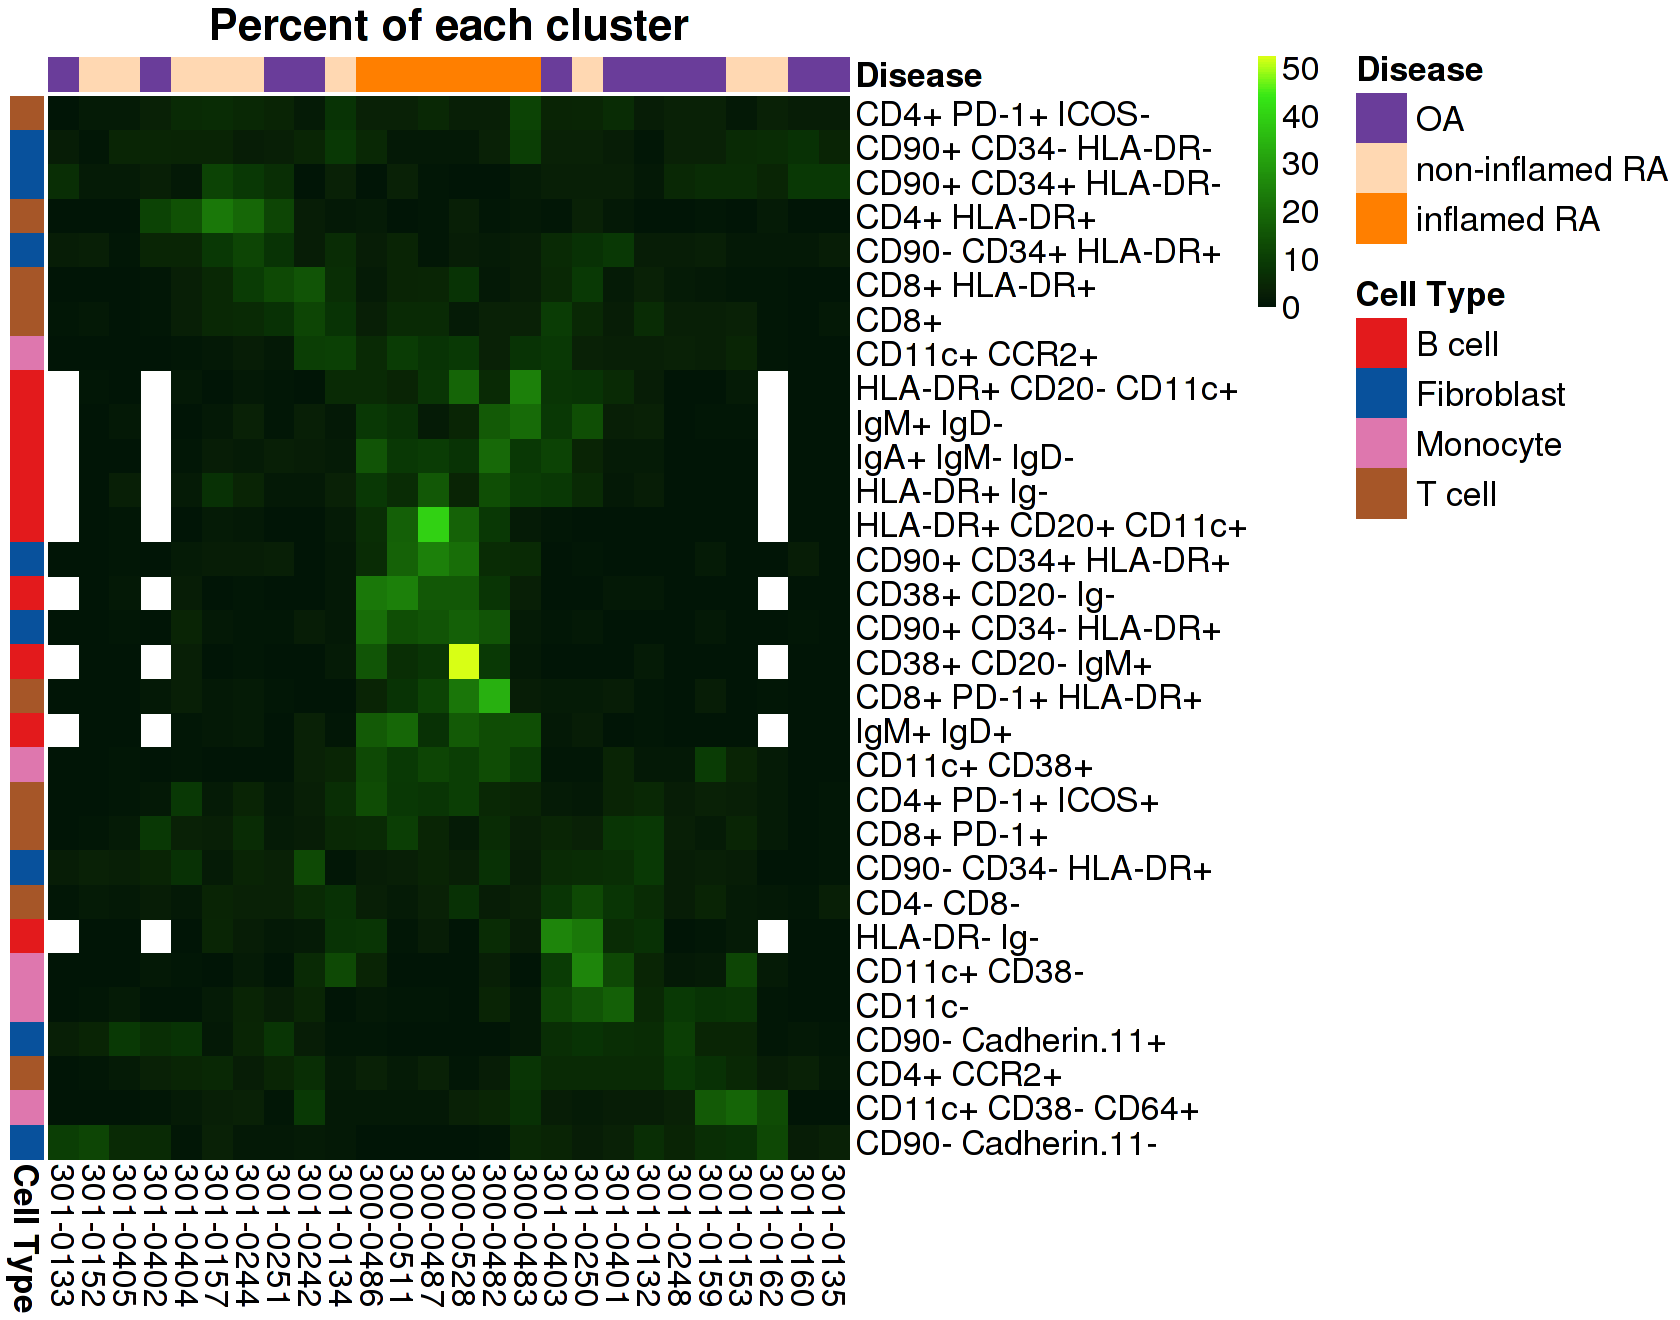

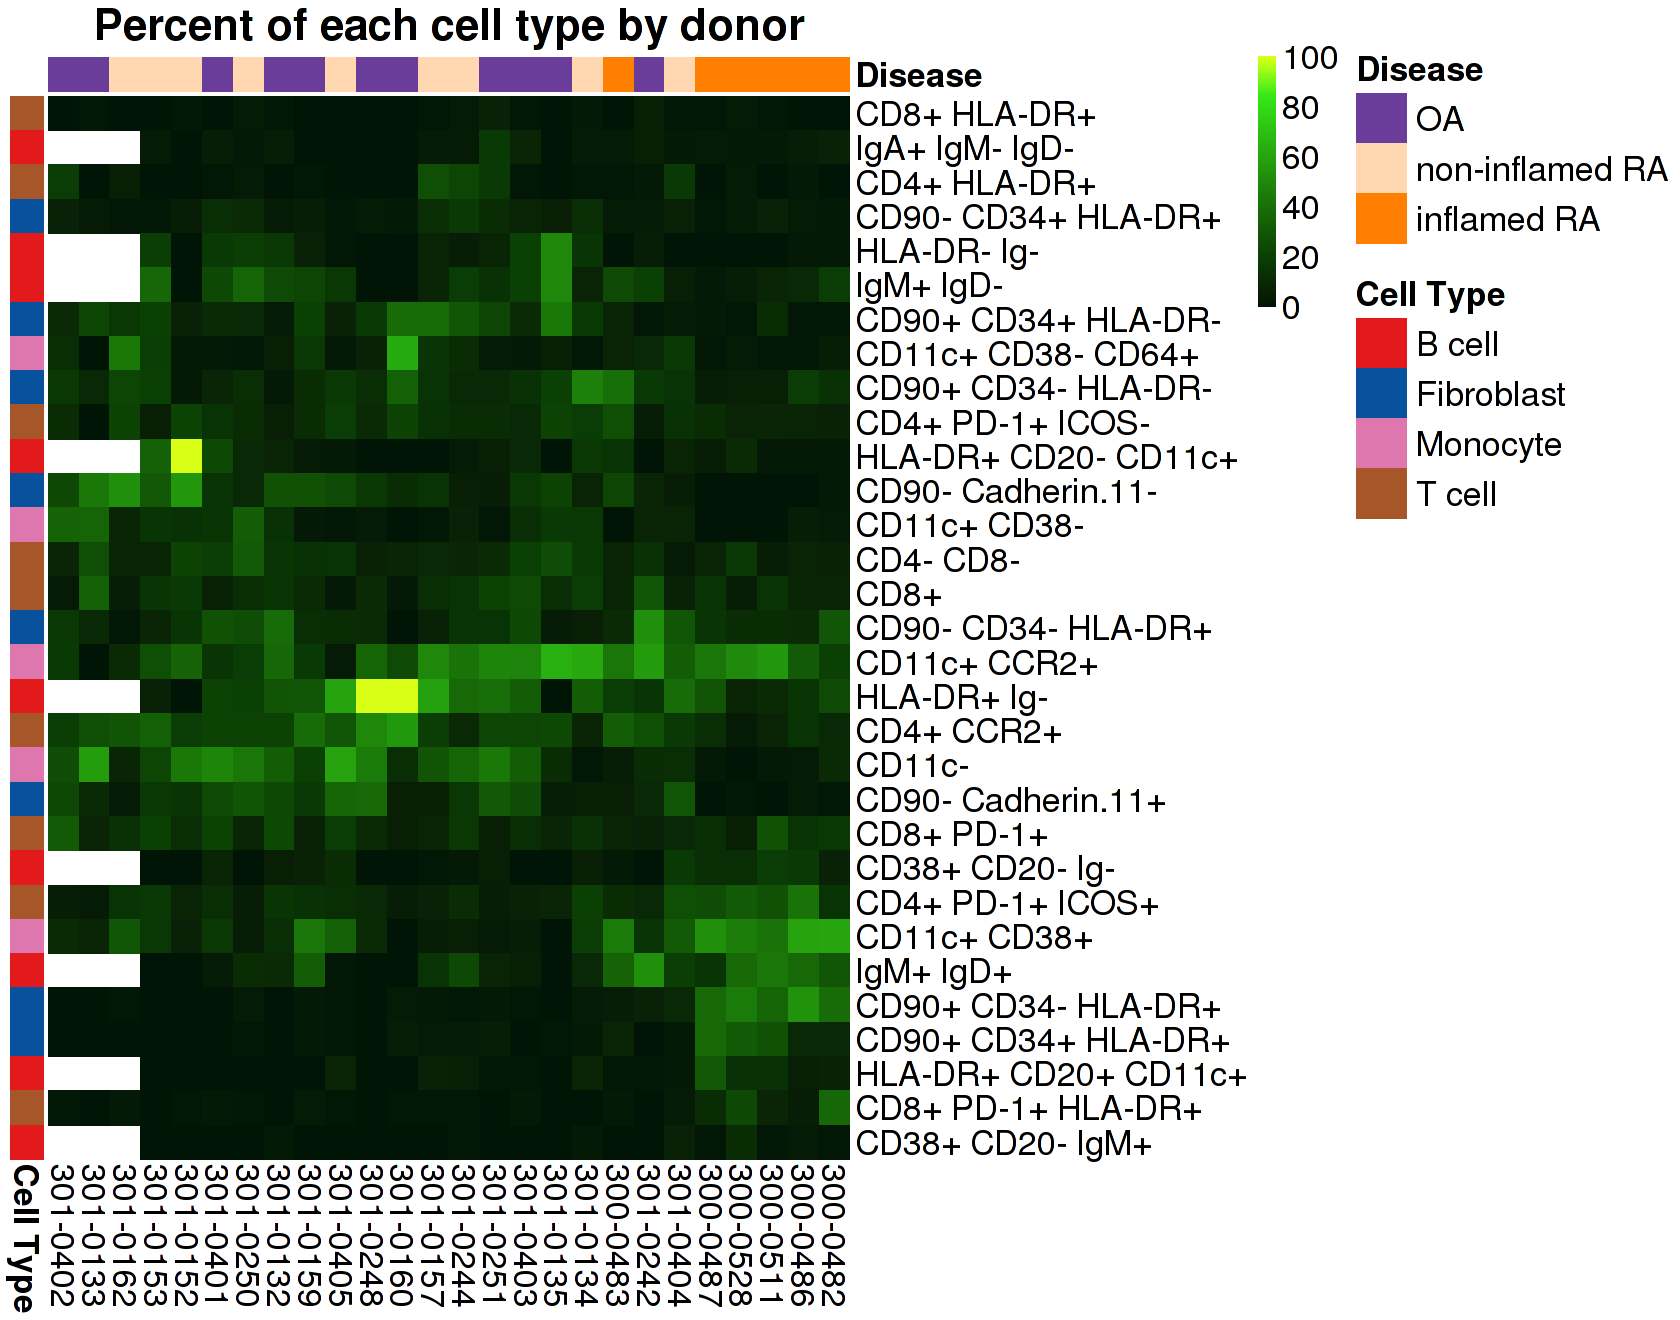

In [11]:
plot_pheatmap <- function(value.var = "percent_donor_cell_type", title = NA) {
  mat <- dcast(data = d, formula = donor ~ cluster, value.var = value.var)
  rownames(mat) <- mat[[1]]
  mat[[1]] <- NULL
  mat <- as.matrix(mat)
  sum(is.na(mat))
  mat[is.na(mat)] <- 1e-6
  mat[1:5,1:5]

  mat_order <- seriate(mat, method = "BEA_TSP")
  mat[mat == 1e-6] <- NA

  mat <- mat[mat_order[[1]], mat_order[[2]]]

  mat <- t(mat)

  d_row <- as.data.frame(unique(d[,c("cluster", "cell_type")]))
  rownames(d_row) <- d_row$cluster
  colnames(d_row) <- c("Cluster", "Cell Type")

  d_col <- as.data.frame(unique(d[,c("donor","Mahalanobis_20")]))
  rownames(d_col) <- d_col$donor
  colnames(d_col) <- c("Donor", "Disease")

  pheatmap(
    fontsize = 20,
    mat = mat,
    border_color = NA,
    color = cet_pal(100, name = "kgy"),
    cluster_rows = FALSE,
    cluster_cols = FALSE,
    annotation_row = d_row[,c("Cell Type"),drop=FALSE],
    annotation_col = d_col[,c("Disease"),drop=FALSE],
    annotation_colors = meta_colors,
    main = title
  )
}

options(repr.plot.width = 14, repr.plot.height = 11)

plot_pheatmap("cells", title = "Cell count")

plot_pheatmap("percent_cluster", title = "Percent of each cluster")

plot_pheatmap("percent_donor_cell_type", title = "Percent of each cell type by donor")

# Alternative heatmaps

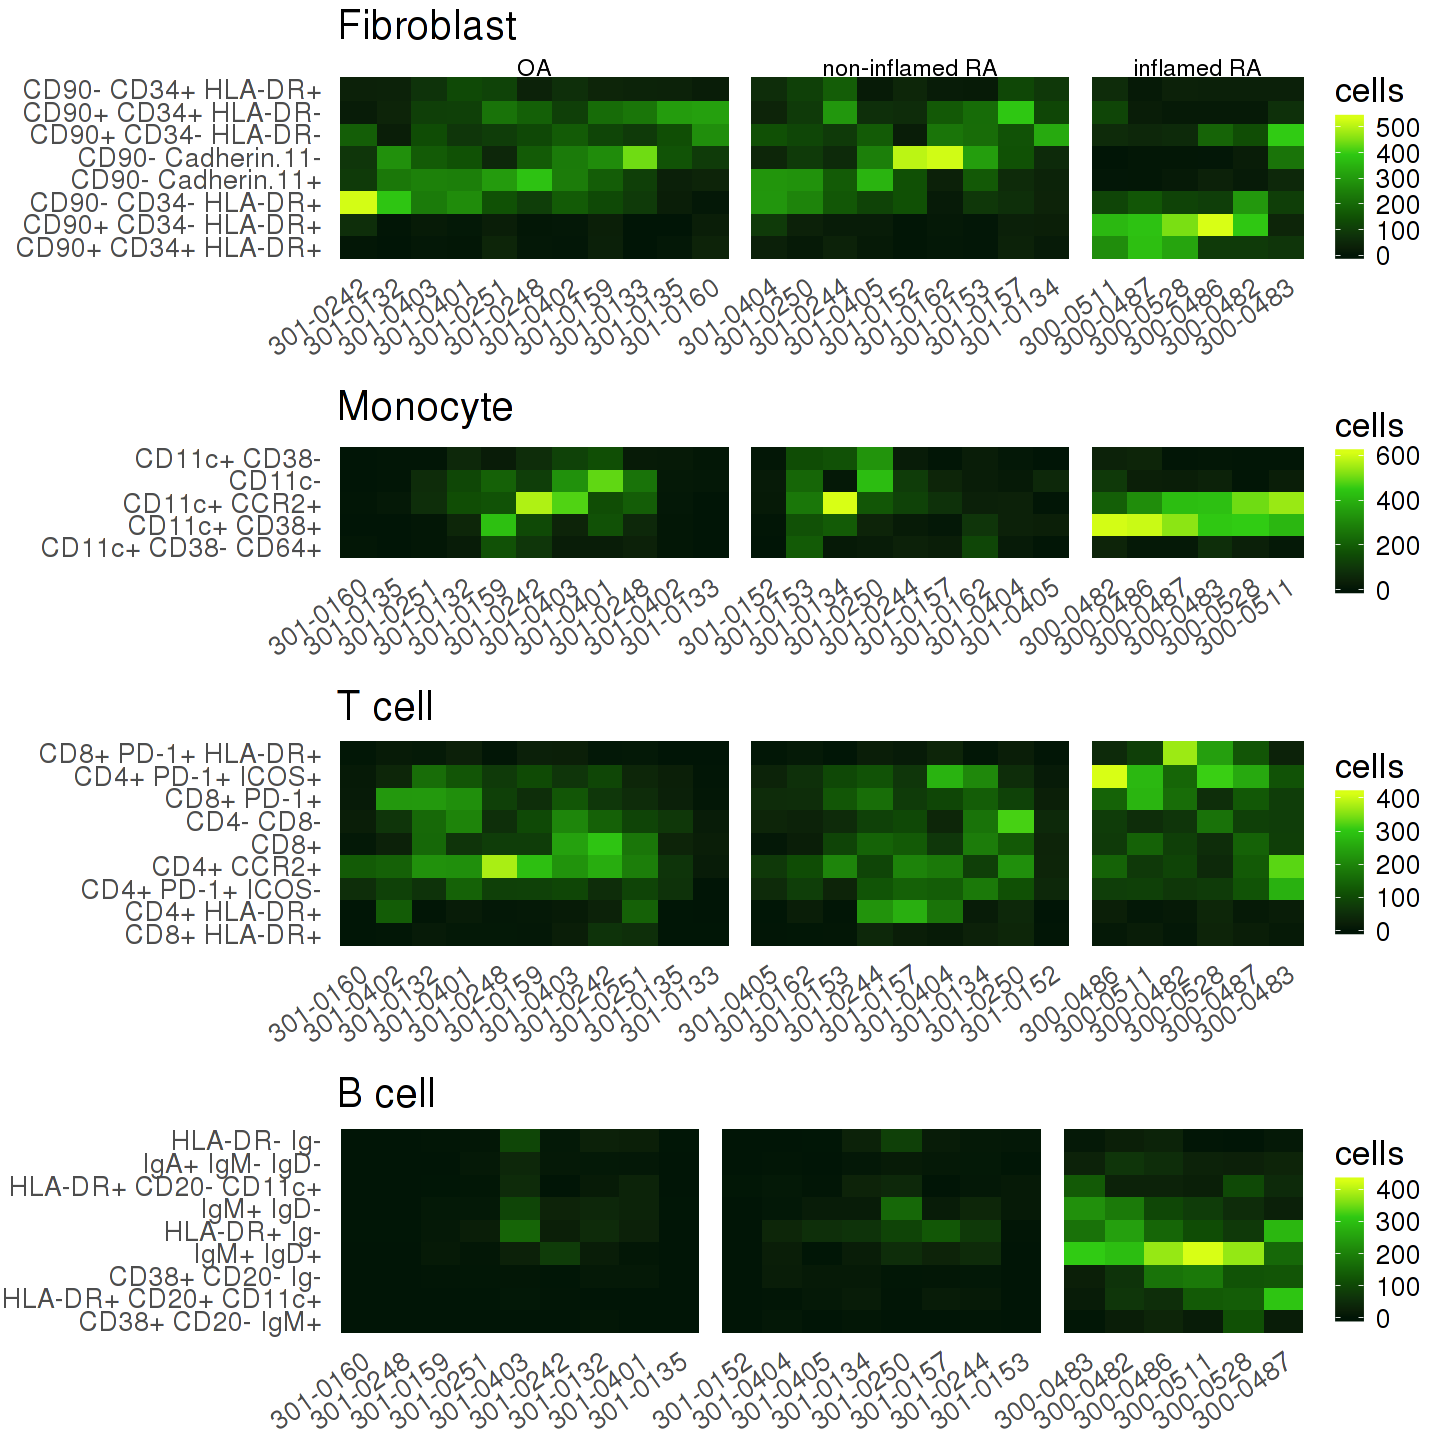

In [12]:
options(repr.plot.width = 12, repr.plot.height = 12)

plot_celltype <- function(this_cell_type) {
  this_d <- subset(d, cell_type == this_cell_type)
  this_d <- seriate_cols(this_d, "donor", "cluster", "cells")
  this_d %<>% arrange(cluster)
  ggplot() +
  geom_tile(
    data = this_d,
    mapping = aes(x = donor, y = cluster, fill = cells)
  ) +
  #facet_wrap(~ Mahalanobis_20, scales = "free_x", drop = TRUE) +
  facet_grid(~ Mahalanobis_20, scales = "free_x", space = "free_x") +
  scale_fill_gradientn(
    colours = cet_pal(5, name = "kgy")
#     breaks = c(0, 50, 100),
#     limits = c(0, 100)
  ) +
  theme_minimal(base_size = 20) +
  theme(
    strip.text = element_blank(),
    strip.background = element_blank(),
    # axis.ticks = element_blank(), 
    panel.grid = element_blank(),
    #axis.text.x = element_text(angle = 35, hjust = 1)
  ) +
  labs(x = NULL, y = NULL, title = this_cell_type)
}

p1 <- plot_celltype("Fibroblast") + theme(axis.text.x = element_text(angle = 35, hjust = 1), strip.text = element_text(size = 14))
p2 <- plot_celltype("Monocyte") + theme(axis.text.x = element_text(angle = 35, hjust = 1))
p3 <- plot_celltype("T cell") + theme(axis.text.x = element_text(angle = 35, hjust = 1))
p4 <- plot_celltype("B cell") + theme(axis.text.x = element_text(angle = 35, hjust = 1))

p1 + p2 + p3 + p4 + plot_layout(
  ncol = 1,
  heights = (unique(d[,c("cluster", "cell_type")]) %>% group_by(cell_type) %>% summarise(clusters = length(cluster)))[[2]]
)

# Bars

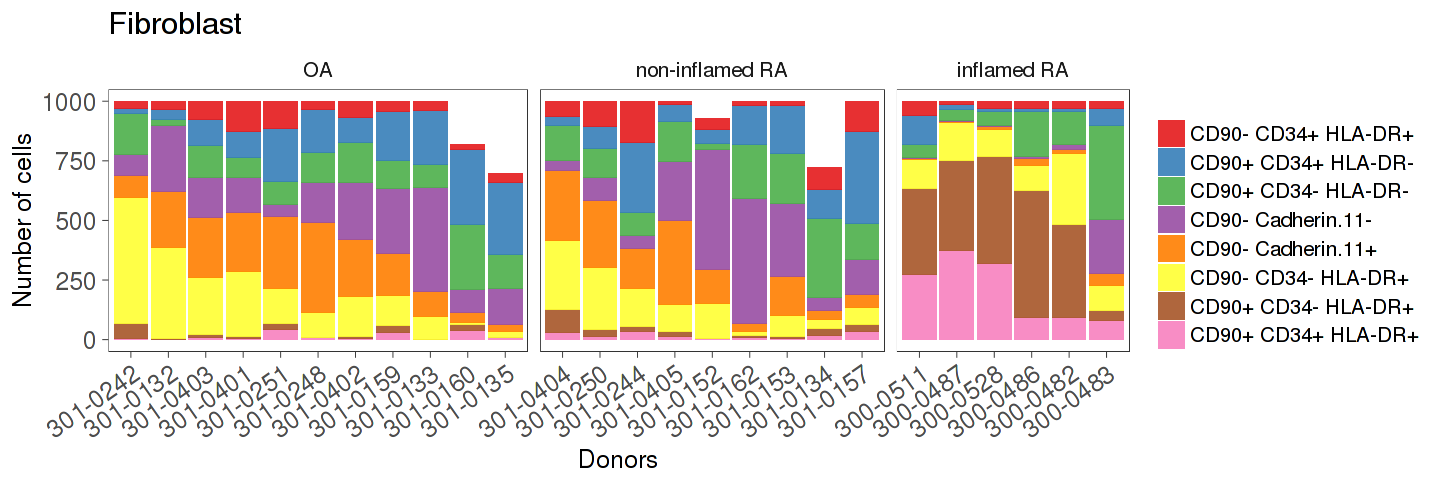

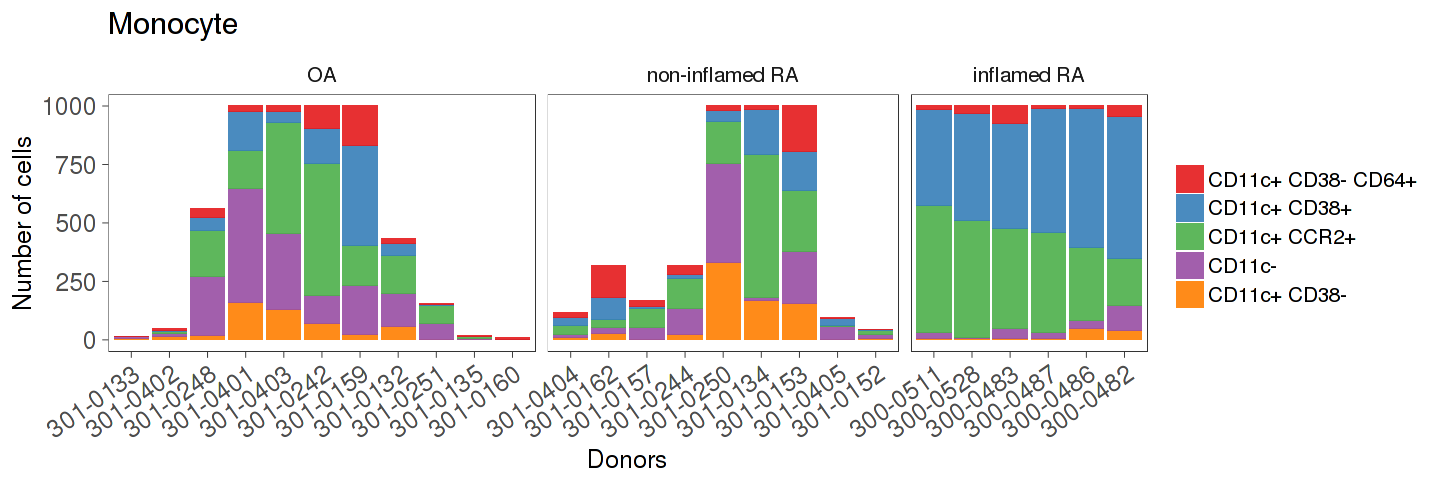

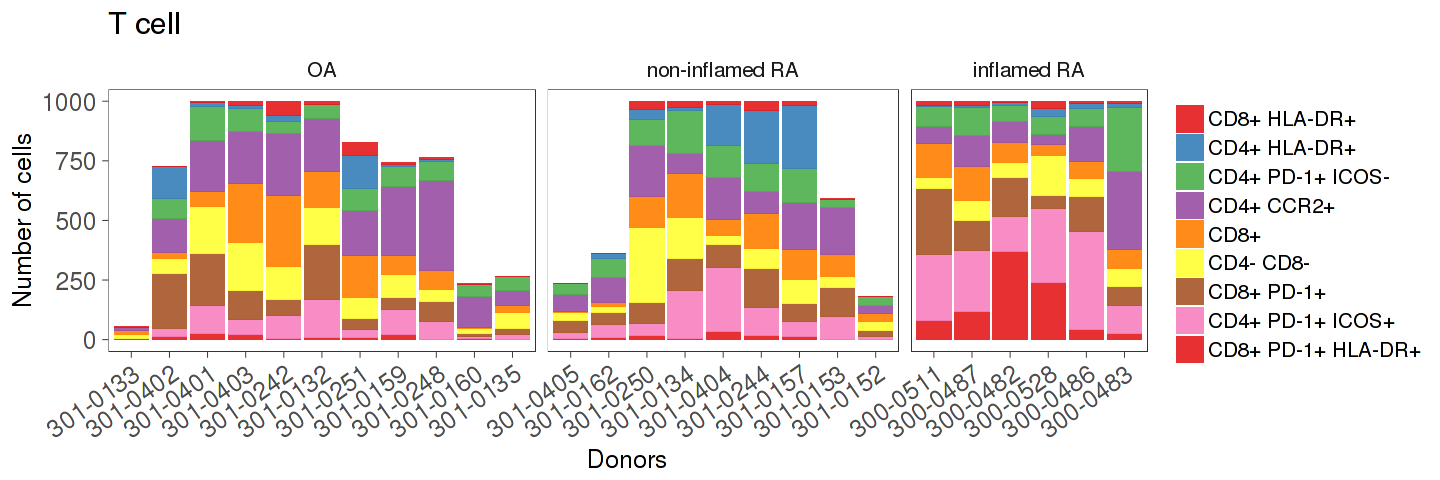

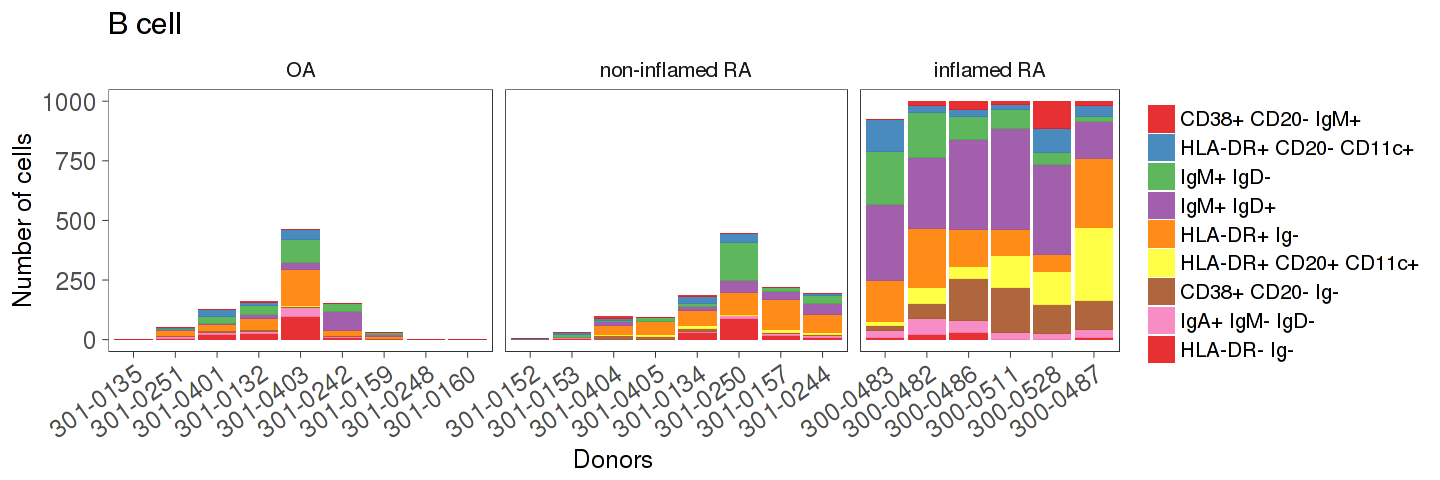

In [13]:
options(repr.plot.width = 12, repr.plot.height = 4)

plot_celltype_bars <- function(this_celltype = "Fibroblast") {
  this_d <- subset(d, cell_type == this_celltype)
  this_d <- seriate_cols(this_d, "donor", "cluster", "cells")
  this_d %<>% arrange(cluster)

  ggplot(
    data = this_d,
    mapping = aes(x = donor, y = cells, fill = cluster)
  ) +
  geom_col() +
  facet_grid( ~ Mahalanobis_20, scales = "free", space = "free_x") +
  scale_fill_manual(
    name = "",
    values = alpha(meta_colors$cytof_cluster, 0.9),
    breaks = levels(this_d$cluster),
    labels = levels(this_d$cluster)
  ) +
  labs(
    x = "Donors",
    y = "Number of cells",
    title = this_celltype
  ) +
  theme_bw(base_size = 15) +
  theme(panel.border = element_rect(size = 0.2),
    axis.ticks = element_line(size = 0.2),
    strip.background = element_blank(),
    # axis.ticks = element_blank(), 
    panel.grid = element_blank(),
    axis.text = element_text(size = 15),
    axis.text.x=element_text(angle = 35, hjust = 1),
    axis.text.y = element_text(size = 15)
  ) 
}

plot_celltype_bars("Fibroblast")
plot_celltype_bars("Monocyte")
plot_celltype_bars("T cell")
plot_celltype_bars("B cell")